### Read in data

In [13]:
library(edgeR)
library(reshape2)
library(tidyr)
library(ggplot2)
library(EnhancedVolcano)
library(countdata)
library(stringr)
#install.packages("ggtern")
library(ggtern)
library(readr)
library(stringr)
library(topGO)
library(dplyr)

# Functions

In [14]:
process_allele_data <- function(data, allele_suffixes, pivot_cols_prefix, id_col = "Synt_ids") {
  # Add ID column if it doesn't already exist
  if (!id_col %in% colnames(data)) {
    data[[id_col]] <- rownames(data)
  }

  # Convert the data to long format
  melted_table <- data %>%
    pivot_longer(
      cols = starts_with(pivot_cols_prefix), # Adjust column name pattern dynamically
      names_to = "variable",
      values_to = "value"
    )

  # Extract allele information based on the provided suffixes
  melted_table <- melted_table %>%
    mutate(
      allele = case_when(
        str_detect(variable, paste0("_", allele_suffixes[1], "$")) ~ paste0("allele_", allele_suffixes[1]),
        str_detect(variable, paste0("_", allele_suffixes[2], "$")) ~ paste0("allele_", allele_suffixes[2]),
        str_detect(variable, paste0("_", allele_suffixes[3], "$")) ~ paste0("allele_", allele_suffixes[3]),
        str_detect(variable, paste0("_", allele_suffixes[4], "$")) ~ paste0("allele_", allele_suffixes[4]),
        TRUE ~ NA_character_
      )
    )

  # Remove rows where allele is NA
  melted_table <- melted_table %>%
    filter(!is.na(allele))

  # Replace allele suffixes in the 'variable' column to create 'base_variable'
  melted_table <- melted_table %>%
    mutate(base_variable = str_remove(variable, paste0("_", paste(allele_suffixes, collapse = "|"), "$")))

  # Optionally extract tissue or other components from 'base_variable' if needed
  if ("base_variable" %in% colnames(melted_table)) {
    melted_table <- melted_table %>%
      mutate(tissue = str_split_fixed(base_variable, "_", 3)[, 2])
  }

  # Pivot the table to have alleles as columns and genes + samples as rows
  pivoted_table <- melted_table %>%
    pivot_wider(
      id_cols = c({{ id_col }}, base_variable), # Rows: gene and sample
      names_from = allele,                     # Columns: alleles
      values_from = value                      # Values: counts
    )

  
  # Add grouped sum counts to the melted table
  # add a column for the sample 
  melted_table$sample = str_extract(melted_table$variable, "SRR\\d*_")
  melted_table = melted_table %>% group_by(Synt_ids, sample) %>% mutate(sum_counts = sum(value))
  list(
    melted_table = melted_table
  )
}

perform_anova_analysis <- function(data, id_col = "Synt_ids", response_var = "value", group_var = "allele", conf_level = 0.95) {
    # Split the data by unique values in the ID column
  split_data <- split(data, data[[id_col]])

  # Perform ANOVA and calculate group means for each subset
  results_list <- lapply(names(split_data), function(id_value) {
    test_data <- split_data[[id_value]]

    # Perform one-way ANOVA
    model <- aov(as.formula(paste(response_var, "~", group_var)), data = test_data)
    test_result <- TukeyHSD(model, conf.level = conf_level)


    # calculate the average of value/sum_counts for each allele
    group_means <- aggregate(
      cbind(value/sum_counts) ~ allele,
      data = test_data,
      FUN = mean
    )
    #print(group_means)
    #group_means$sum_counts <- test_data$sum_counts.unique()
    #group_means$mean <- group_means$value/ group_means$sum_counts

  

    # Extract p-values and means
    return(data.frame(
      Synt_id = id_value,
      p_value_2_1 = ifelse(!is.null(test_result$allele[1, "p adj"]), test_result$allele[1, "p adj"], NA),
      p_value_3_1 = ifelse(!is.null(test_result$allele[2, "p adj"]), test_result$allele[2, "p adj"], NA),
      p_value_4_1 = ifelse(!is.null(test_result$allele[3, "p adj"]), test_result$allele[3, "p adj"], NA),
      p_value_3_2 = ifelse(!is.null(test_result$allele[4, "p adj"]), test_result$allele[4, "p adj"], NA),
      p_value_4_2 = ifelse(!is.null(test_result$allele[5, "p adj"]), test_result$allele[5, "p adj"], NA),
      p_value_4_3 = ifelse(!is.null(test_result$allele[6, "p adj"]), test_result$allele[6, "p adj"], NA),
      mean_group1 = ifelse(length(group_means$V1) >= 1, group_means$V1[1], NA),
      mean_group2 = ifelse(length(group_means$V1) >= 2, group_means$V1[2], NA),
      mean_group3 = ifelse(length(group_means$V1) >= 3, group_means$V1[3], NA),
      mean_group4 = ifelse(length(group_means$V1) >= 4, group_means$V1[4], NA)
    ))
  })

  # Combine the list of data frames into a single data frame
  results_df <- do.call(rbind, results_list)

  return(results_df)
}

# Example usage:
# results_df <- perform_anova_analysis(melted_table)
### Plot
analyze_significance_and_plot <- function(results_df, raw_counts, length_category_col = "mismatch_category", p_value_threshold = 0.05, sample_name = "") {
  # adjust the p-values for multiple testing
  results_df$p_value_2_1_adj = p.adjust(results_df$p_value_2_1, method = "fdr")
  results_df$p_value_3_1_adj = p.adjust(results_df$p_value_3_1, method = "fdr")
  results_df$p_value_4_1_adj = p.adjust(results_df$p_value_4_1, method = "fdr")
  results_df$p_value_3_2_adj = p.adjust(results_df$p_value_3_2, method = "fdr")
  results_df$p_value_4_2_adj = p.adjust(results_df$p_value_4_2, method = "fdr")
  results_df$p_value_4_3_adj = p.adjust(results_df$p_value_4_3, method = "fdr")
  
  # Add a column to indicate significance based on p-value threshold
  results_df <- results_df %>%
    mutate(
      significant = ifelse(
        p_value_2_1_adj < p_value_threshold | 
          p_value_3_1_adj < p_value_threshold | 
          p_value_4_1_adj < p_value_threshold | 
          p_value_3_2_adj < p_value_threshold | 
          p_value_4_2_adj < p_value_threshold | 
          p_value_4_3_adj < p_value_threshold, 
        "yes", "no"
      )
    )


  # Add length category column
  raw_counts$Synt_id = rownames(raw_counts)
  results_df  = results_df |> 
    left_join(raw_counts, join_by('Synt_id'))

  print(head(results_df))
  # Generate ternary plot with significance
  plot_significance <- ggtern(data = results_df, aes(mean_group1, mean_group2, mean_group3, color = significant)) +
    geom_point() +
    theme_bw() +
    xlab("Allele1") +
    ylab("Allele2") +
    zlab("Allele3") +
    Tlab("Allele1") +
    Llab("Allele2") +
    Rlab("Allele3") +
    theme_showarrows() +
    ggtitle(paste("Ternary Plot (Significance) -", sample_name))

  plot_significance <- ggtern(data = results_df, aes(mean_group1, mean_group2, mean_group3, color = significant)) +
  stat_density_tern(geom = 'polygon', data = results_df, aes(mean_group1, mean_group2, mean_group3, alpha  = mean_group4)) +
  geom_point() +
  scale_fill_gradient(low = "blue", high = "red", name = "", breaks = 1:4, 
                      labels = c("low", "", "", "high"))  +
  scale_L_continuous(breaks = 0:4 / 4, labels = 0:4/ 4) +
  scale_R_continuous(breaks = 0:4 / 4, labels = 0:4/ 4) +
  scale_T_continuous(breaks = 0:4 / 4, labels = 0:4/ 4) +
  labs(title = "Example Density/Contour Plot") +
  guides(fill = guide_colorbar(order = 1), alpha = guide_none()) +
  theme_rgbg() +
  theme_noarrows() +
  theme(legend.justification = c(0, 1), 
        legend.position      = c(0, 1))

  # Generate ternary plot with length category
  plot_length_category <- ggtern(data = results_df, aes(mean_group1, mean_group2, mean_group3, color = length_category)) +
    geom_point() +
    theme_bw() +
    xlab("Allele1") +
    ylab("Allele2") +
    zlab("Allele3") +
    Tlab("Allele1") +
    Llab("Allele2") +
    Rlab("Allele3") +
    theme_showarrows() +
    theme(axis.text.y = element_text(size = 16), axis.text.x = element_text(size = 16))
    ggtitle(paste("Ternary Plot (Length Category) -", sample_name))

   # Generate ternary plot with length category
  plot_multi <- ggtern(data = results_df, aes(mean_group1, mean_group2, mean_group3, color =  multimapping_tag)) +
    geom_point() +
    theme_bw() +
    xlab("Allele1") +
    ylab("Allele2") +
    zlab("Allele3") +
    Tlab("Allele1") +
    Llab("Allele2") +
    Rlab("Allele3") +
    theme_showarrows() +
    theme(axis.text.y = element_text(size = 16), axis.text.x = element_text(size = 16))
    ggtitle(paste("Ternary Plot (Length Category) -", sample_name))
  

  # Count the number of genes with significant differences
  significance_summary <- results_df %>%
    group_by(significant) %>%
    summarise(n = n())

  # Summarize data
  plot_df <- results_df %>%
    summarize(
      Significant = sum(significant == "yes"),
      Total = n()
    ) %>%
    tidyr::pivot_longer(
      cols = c(Significant, Total),
      names_to = "category",
      values_to = "count"
    )

  # Plot the summarized data
  bar_plot <- ggplot(plot_df, aes(x = category, y = count, fill = category)) +
    geom_col() +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
      axis.text.y = element_text(size = 16),
      axis.title.x = element_text(size = 16),
      axis.title.y = element_text(size = 16),
      plot.title = element_text(size = 16, face = "bold")
    ) +
    labs(
      title = paste("Distribution of Tested Genes -", sample_name),
      x = "Category",
      y = "Number of Genes"
    )
  
  return(list(
    plot_significance = plot_significance,
    plot_length_category = plot_length_category,
    significance_summary = significance_summary,
    bar_plot = bar_plot, 
    results_df = results_df
  ))
}

# Example usage:
# plots_and_summary <- analyze_significance_and_plot(results_df, raw_counts, sample_name = "Tuber")
# print(plots_and_summary$plot_significance)
# print(plots_and_summary$plot_length_category)
# print(plots_and_summary$bar_plot)
# View(plots_and_summary$significance_summary)


# Analysis

## Preparing data

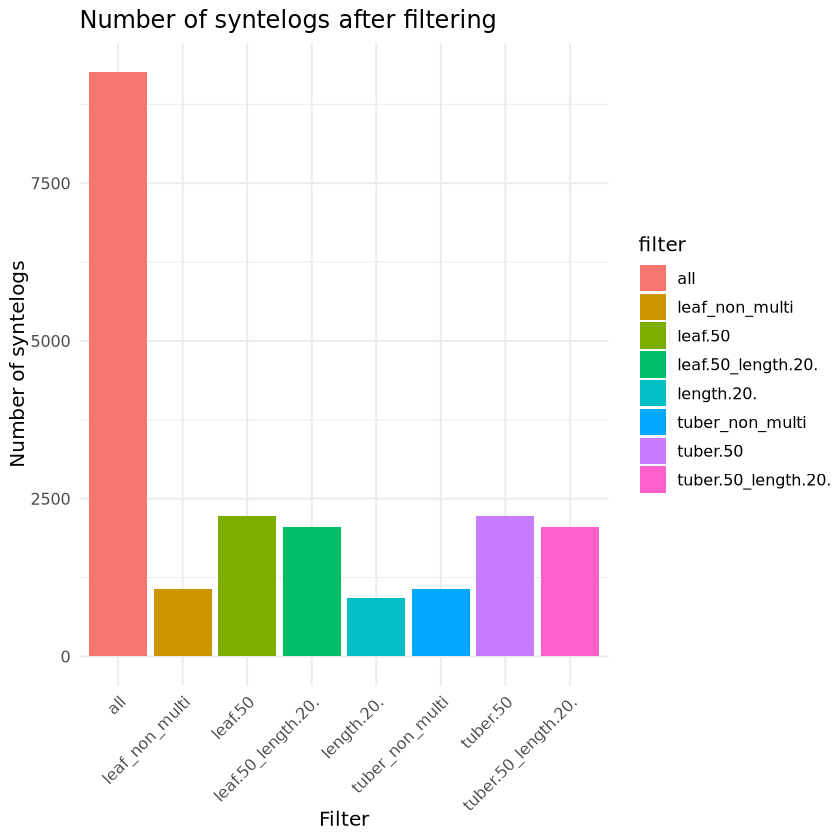

In [15]:
raw_counts = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_all.tsv"
info = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_with_info.tsv"

# read in tabel with raw counts
raw_counts = read.table(raw_counts, header = TRUE, sep = "\t")
# normalize the raw counts by the library size
info = read.table(info, header = TRUE, sep = "\t")
# merge the two tables on the column "Synt_id"
raw_counts = merge(raw_counts, info, by = "Synt_id")
# set synt_id as rownames
rownames(raw_counts) = raw_counts$Synt_id
# remove the column "Synt_id"
raw_counts = raw_counts[,-1]
# replaace NA values with 0
raw_counts[is.na(raw_counts)] = 0
# filter the genes that have length_category == more_20%_difference and mulitmapping_tag = mulitmapping 
#raw_counts_filter = raw_counts[raw_counts$multi_ratio <= 0.05,]
#raw_counts_filter = raw_counts[raw_counts$length_category != "more_20%_difference" & raw_counts$multi_ratio <= 0.10,]
# get the sample columns starting with SRR
sample_columns = colnames(raw_counts)[grep("SRR", colnames(raw_counts))]
# filter for synts that have at least 10 counts for each allele 
#raw_counts_filter = raw_counts_filter[rowSums(raw_counts_filter[,allele_1]) > 10 & rowSums(raw_counts_filter[,allele_2]) > 10 & rowSums(raw_counts_filter[,allele_3]) > 10 & rowSums(raw_counts_filter[,allele_4]) > 10,]
leaf_samples = colnames(raw_counts)[grep("leaf", colnames(raw_counts))]
tuber_samples = colnames(raw_counts)[grep("tuber", colnames(raw_counts))]

# get the number of syntelogs that have at least 50 counts in the tuber samples
syntelogs_leaf_50 = raw_counts[rowSums(raw_counts[,leaf_samples]) >= 100 & rowSums(raw_counts[,tuber_samples]) >= 100,]
syntelogs_tuber_50 = raw_counts[rowSums(raw_counts[,tuber_samples]) >= 100 & rowSums(raw_counts[,leaf_samples]) >= 100,]

# get the synt ids with large difference in length
syntelogs_length = raw_counts[raw_counts$length_category == "more_20%_difference",]
syntelogs_tuber_50_length_20diff = syntelogs_tuber_50[syntelogs_tuber_50$length_category != "more_20%_difference",]
syntelogs_leaf_50_length_20diff = syntelogs_leaf_50[syntelogs_leaf_50$length_category != "more_20%_difference",]

syntelogs_tuber_50_non_multi = syntelogs_tuber_50_length_20diff[syntelogs_tuber_50_length_20diff$multi_ratio < 0.25,][tuber_samples]
syntelogs_leaf_50_non_multi = syntelogs_leaf_50_length_20diff[syntelogs_leaf_50_length_20diff$multi_ratio < 0.25,][leaf_samples]


# make a dataframe for the number of syntelogs that are left after the filtering steps
syntelogs = data.frame("all" = nrow(info), "leaf>50" = nrow(syntelogs_leaf_50), "tuber>50" = nrow(syntelogs_tuber_50), "leaf_non_multi" = nrow(syntelogs_leaf_50_non_multi), "tuber_non_multi" = nrow(syntelogs_tuber_50_non_multi), "length>20%" = nrow(syntelogs_length), "tuber>50_length>20%" = nrow(syntelogs_tuber_50_length_20diff), "leaf>50_length>20%" = nrow(syntelogs_leaf_50_length_20diff))

# make a barplot of the number of syntelogs that are left after the filtering steps
syntelogs = syntelogs %>% gather(key = "filter", value = "number")
ggplot(syntelogs, aes(x = filter, y = number, fill = filter)) + geom_bar(stat = "identity") + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = "Number of syntelogs after filtering", x = "Filter", y = "Number of syntelogs")


# no filtering !!!!
#
 
# syntelogs_leaf_50_non_multi = syntelogs_leaf_50_length_20diff[leaf_samples]
# syntelogs_tuber_50_non_multi = syntelogs_tuber_50_length_20diff[tuber_samples]

## check the ratios

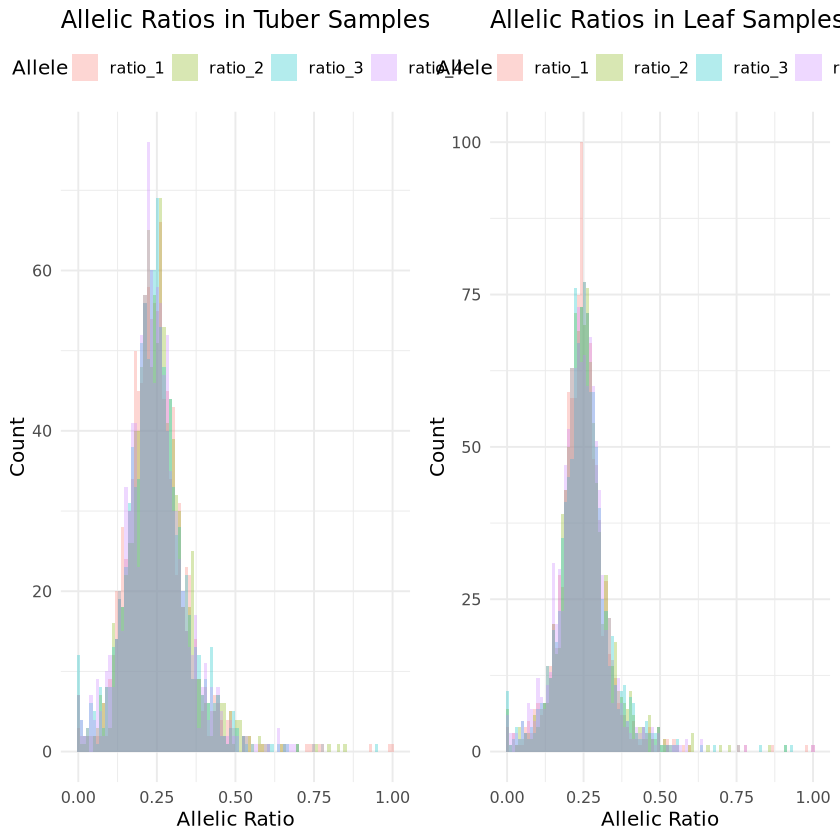

In [16]:

# Function to compute allelic ratios and plot histograms
compute_and_plot_allelic_ratios <- function(data, sample_type) {
  # Identify all alleles based on column names
  alleles <- unique(sub(".*_", "", colnames(data)))
  
  # Compute allelic ratios for each allele
  for (allele in alleles) {
    # Numerator: columns corresponding to the current allele
    num_cols <- grep(paste0("_", allele), colnames(data))
    
    # Denominator: sum of all allele columns
    denom_cols <- grep(paste0("_", paste(alleles, collapse = "|")), colnames(data))
    
    # Calculate ratio
    data[[paste0("ratio_", allele)]] <- rowSums(data[, num_cols]) / rowSums(data[, denom_cols])
  }
  # Gather the data into long format for ggplot
  allelic_ratios <- data %>%
    dplyr::select(starts_with("ratio_")) %>%
    gather(key = "allele", value = "ratio")
  # Plot overlaid histograms
  ggplot(allelic_ratios, aes(x = ratio, fill = allele)) +
    geom_histogram(position = "identity", alpha = 0.3, bins = 100) +
    theme_minimal() +
    labs(
      title = paste("Allelic Ratios in", sample_type, "Samples"),
      x = "Allelic Ratio",
      y = "Count",
      fill = "Allele"
    ) +
    theme(legend.position = "top")
}
# plot side by side histograms for the tuber and leaf samples

plot1 = compute_and_plot_allelic_ratios(syntelogs_tuber_50_non_multi, sample_type = "Tuber")
plot2 = compute_and_plot_allelic_ratios(syntelogs_leaf_50_non_multi, sample_type = "Leaf")
grid.arrange(plot1, plot2, ncol=2)


## Normalizing 

Warning message:
“Removed 731 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 4405 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Adding missing grouping variables: `sample_type`


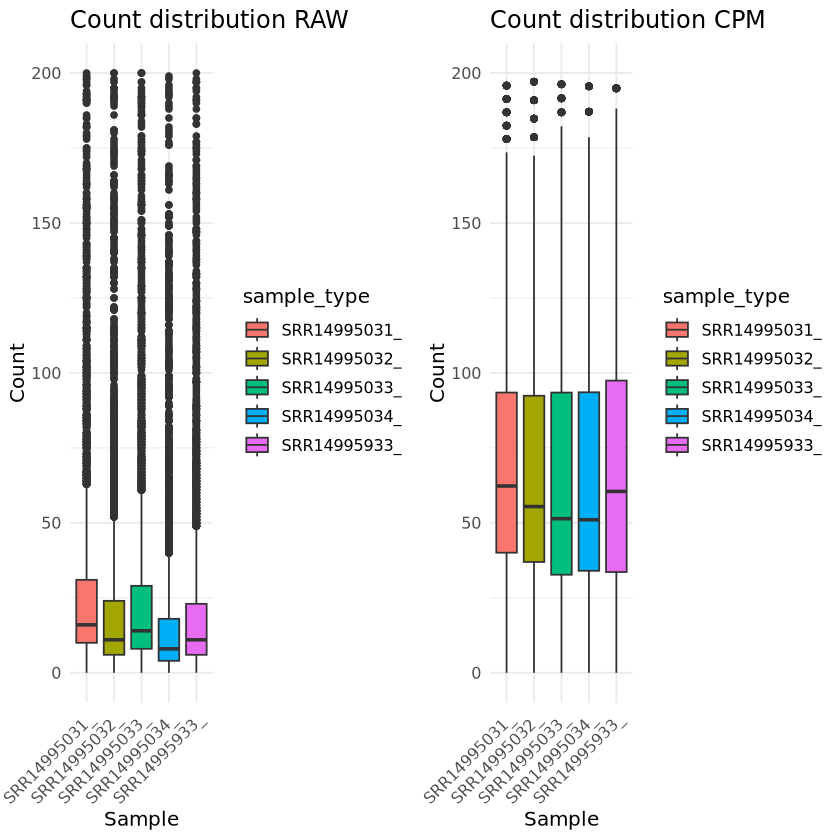

In [17]:
# make a boxplot to view the count dirstributions per sample
# gather the data into long format for ggplot and keep the Synt id
syntelogs_tuber_50_non_multi$Synt_id = rownames(syntelogs_tuber_50_non_multi)

syntelogs_tuber_50_non_multi_long = syntelogs_tuber_50_non_multi %>% gather(key = "sample", value = "count", starts_with("SRR"))
# add a column for the first part of the sample name
syntelogs_tuber_50_non_multi_long$sample_type <- str_extract(syntelogs_tuber_50_non_multi_long$sample, "SRR\\d*_")

# plot the boxplot
plot1 = ggplot(syntelogs_tuber_50_non_multi_long, aes(x = sample_type, y = count, fill = sample_type)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = "Count distribution RAW", x = "Sample", y = "Count") + ylim(0, 200)

# for each sample sum up all the counts 
syntelogs_tuber_50_non_multi_long = syntelogs_tuber_50_non_multi_long %>% group_by(sample_type) %>% mutate(library_factor = 1/sum(count) * 1e6)
syntelogs_tuber_50_non_multi_long$cpm_counts = syntelogs_tuber_50_non_multi_long$count * syntelogs_tuber_50_non_multi_long$library_factor

plot2 = ggplot(syntelogs_tuber_50_non_multi_long, aes(x = sample_type, y = cpm_counts, fill = sample_type)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = "Count distribution CPM", x = "Sample", y = "Count") + ylim(0, 200)
grid.arrange(plot1, plot2, ncol=2)
# convert back to wide format
syntelogs_tuber_50_non_multi_cpm = syntelogs_tuber_50_non_multi_long %>% 
                                 dplyr::select(-count, -sample_type, -library_factor) %>%
                                 pivot_wider(id_cols = Synt_id, names_from = sample, values_from = cpm_counts)
# convert to dataframe
syntelogs_tuber_50_non_multi_cpm = as.data.frame(syntelogs_tuber_50_non_multi_cpm)
# set the rownames to Synt_id
rownames(syntelogs_tuber_50_non_multi_cpm) = syntelogs_tuber_50_non_multi_cpm$Synt_id
# remove the column Synt_id
syntelogs_tuber_50_non_multi_cpm = syntelogs_tuber_50_non_multi_cpm[,-1]

Warning message:
“Removed 1361 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 5558 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Adding missing grouping variables: `sample_type`


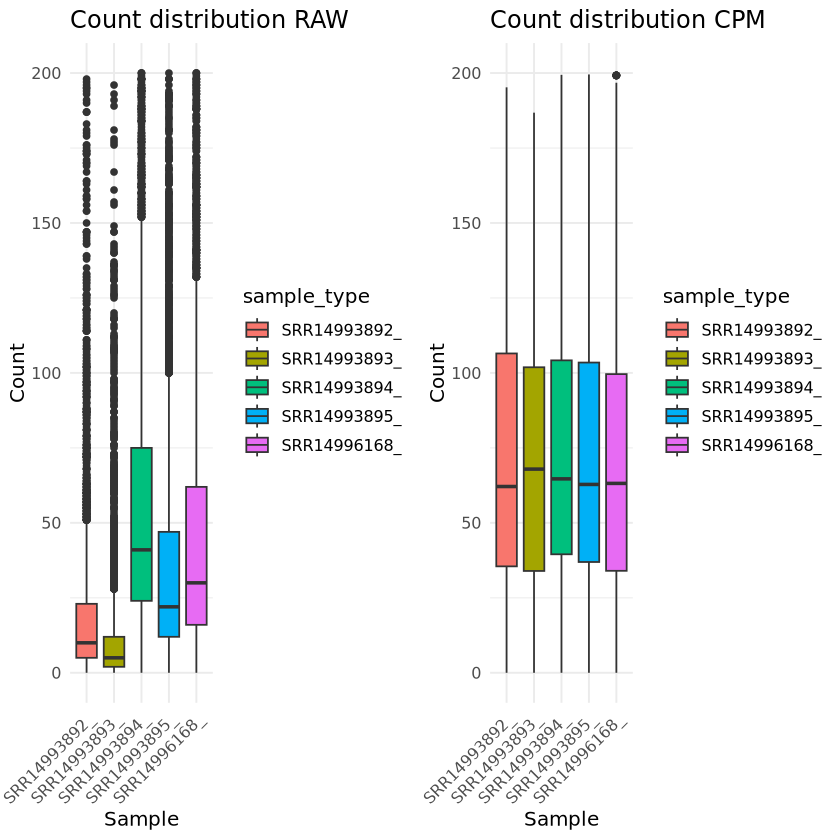

In [18]:
# make a boxplot to view the count dirstributions per sample
# gather the data into long format for ggplot and keep the Synt id
syntelogs_leaf_50_non_multi$Synt_id = rownames(syntelogs_leaf_50_non_multi)

syntelogs_leaf_50_non_multi_long = syntelogs_leaf_50_non_multi %>% gather(key = "sample", value = "count", starts_with("SRR"))
# add a column for the first part of the sample name
syntelogs_leaf_50_non_multi_long$sample_type <- str_extract(syntelogs_leaf_50_non_multi_long$sample, "SRR\\d*_")

# plot the boxplot
plot1 = ggplot(syntelogs_leaf_50_non_multi_long, aes(x = sample_type, y = count, fill = sample_type)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = "Count distribution RAW", x = "Sample", y = "Count") + ylim(0, 200)

# for each sample sum up all the counts 
syntelogs_leaf_50_non_multi_long = syntelogs_leaf_50_non_multi_long %>% group_by(sample_type) %>% mutate(library_factor = 1/sum(count) * 1e6)
syntelogs_leaf_50_non_multi_long$cpm_counts = syntelogs_leaf_50_non_multi_long$count * syntelogs_leaf_50_non_multi_long$library_factor

plot2 = ggplot(syntelogs_leaf_50_non_multi_long, aes(x = sample_type, y = cpm_counts, fill = sample_type)) + geom_boxplot() + theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + labs(title = "Count distribution CPM", x = "Sample", y = "Count") + ylim(0, 200)
grid.arrange(plot1, plot2, ncol=2)
# convert back to wide format
syntelogs_leaf_50_non_multi_cpm = syntelogs_leaf_50_non_multi_long %>% 
                                 dplyr::select(-count, -sample_type, -library_factor) %>%
                                 pivot_wider(id_cols = Synt_id, names_from = sample, values_from = cpm_counts)
# convert to dataframe
syntelogs_leaf_50_non_multi_cpm = as.data.frame(syntelogs_leaf_50_non_multi_cpm)
# set the rownames to Synt_id
rownames(syntelogs_leaf_50_non_multi_cpm) = syntelogs_leaf_50_non_multi_cpm$Synt_id
# remove the column Synt_id
syntelogs_leaf_50_non_multi_cpm = syntelogs_leaf_50_non_multi_cpm[,-1]



## ANOVA

### Test Leaf

                   SRR14993892_leaf_1 SRR14993892_leaf_2 SRR14993892_leaf_3
Soltu.DM.01G000010                  4                 12                 11
Soltu.DM.01G000030                  9                  0                 11
Soltu.DM.01G000040                  0                  2                  4
Soltu.DM.01G000050                  6                  0                  3
Soltu.DM.01G000060                  7                137                  2
Soltu.DM.01G000070                  2                  0                  3
                   SRR14993892_leaf_4 SRR14993893_leaf_1 SRR14993893_leaf_2
Soltu.DM.01G000010                  6                  5                  4
Soltu.DM.01G000030                  0                  6                  0
Soltu.DM.01G000040                  0                  3                  2
Soltu.DM.01G000050                  0                  3                  1
Soltu.DM.01G000060                 84                  2                 80
Soltu.DM.01G

Warning message:
“Removed 10 rows containing non-finite outside the scale range
(`StatDensityTern()`).”
Warning message:
“stat_density_tern: You have not specified a below-detection-limit (bdl) value (Ref. 'bdl' and 'bdl.val' arguments in ?stat_density_tern). Presently you have 4x value/s below a detection limit of 0.010, which acounts for 1.338% of your data. Density values at fringes may appear abnormally high attributed to the mathematics of the ILR transformation. 
You can either:
1. Ignore this warning,
2. Set the bdl value appropriately so that fringe values are omitted from the ILR calculation, or
3. Accept the high density values if they exist, and manually set the 'breaks' argument 
   so that the countours at lower densities are represented appropriately.”
Warning message:
“The following aesthetics were dropped during statistical transformation: alpha.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `gro

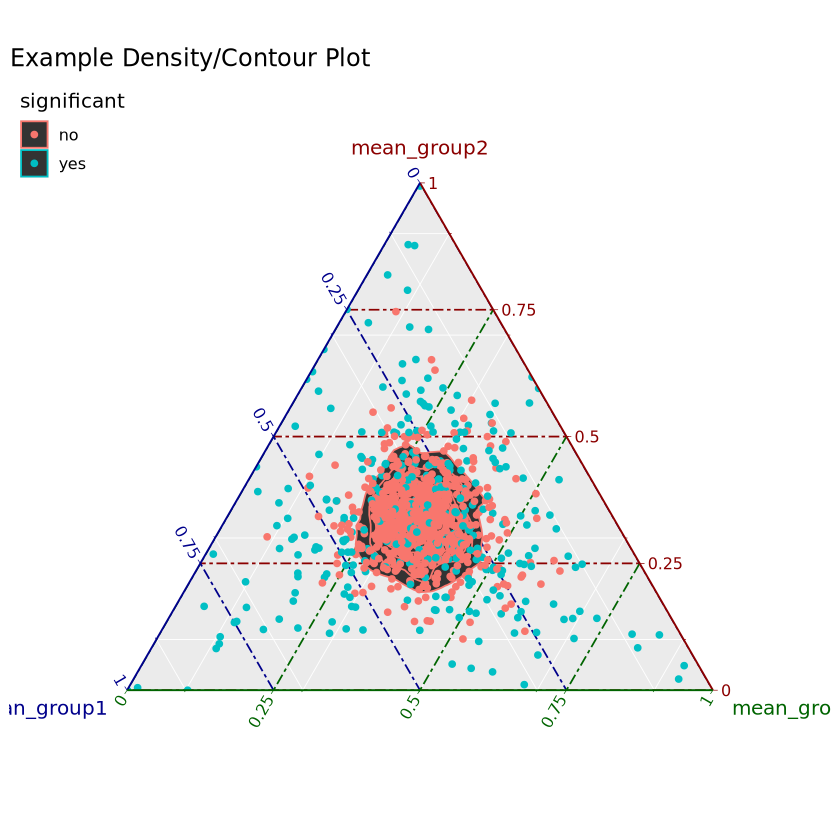

NULL

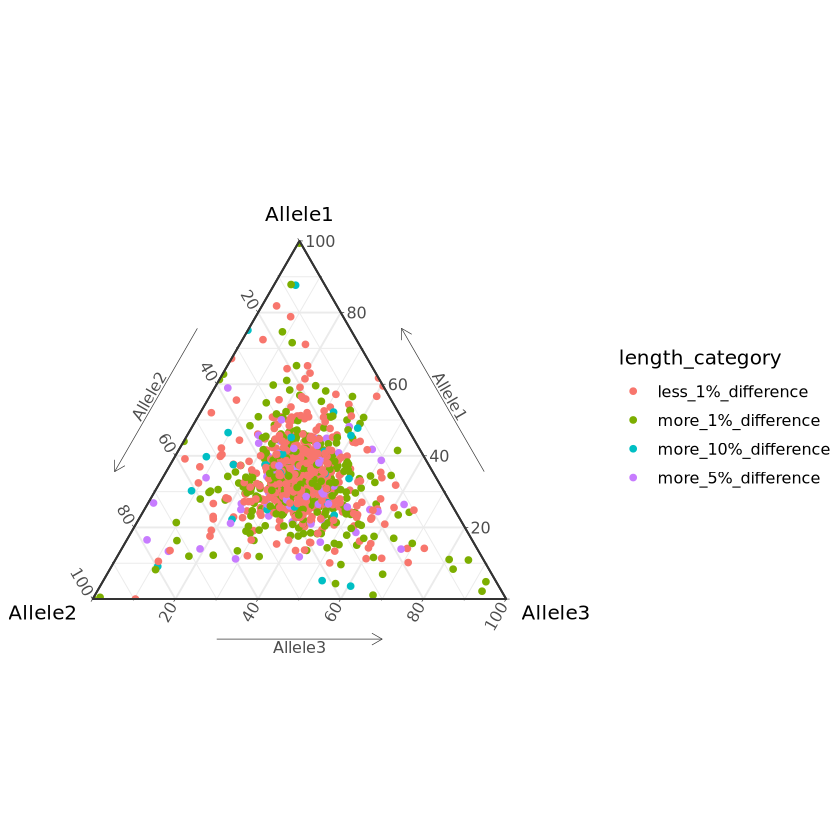

significant,n
<chr>,<int>
no,760
yes,309


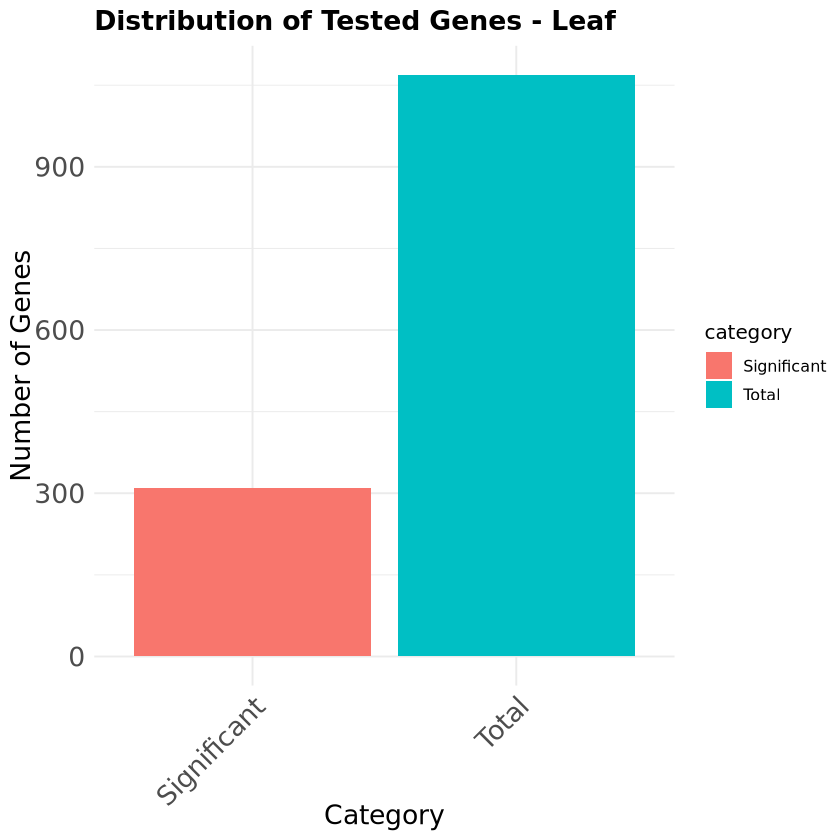

In [19]:
result <- process_allele_data(syntelogs_leaf_50_non_multi_cpm, allele_suffixes = c("1", "2", "3", "4"), pivot_cols_prefix = "SRR")
melted_table <- result$melted_table
pivoted_table <- result$pivoted_table
results_df <- perform_anova_analysis(melted_table)
print(head(raw_counts))
plots_and_summary_leaf <- analyze_significance_and_plot(results_df, raw_counts, sample_name = "Leaf", p_value_threshold = 0.01)
plots_and_summary_leaf$plot_significance
plots_and_summary_leaf$plot_length_category
plots_and_summary_leaf$plot_DM_blast
plots_and_summary_leaf$bar_plot
#grid.arrange(plot1, plot2, plot3, ncol=1)
View(plots_and_summary_leaf$significance_summary)

### Test Tuber

             Synt_id  p_value_2_1  p_value_3_1 p_value_4_1  p_value_3_2
1 Soltu.DM.01G000010 0.8165950074 0.5575944489 0.831831818 0.1632073997
2 Soltu.DM.01G000120 0.9527637271 0.0009585621 0.986282044 0.0003428016
3 Soltu.DM.01G000290 0.0000379392 0.0967860959 0.003075821 0.0049640877
4 Soltu.DM.01G000350 0.9657342284 0.3704337956 0.944944584 0.6323247954
5 Soltu.DM.01G000360 0.2200117218 0.0039258026 0.008078112 0.1933090798
6 Soltu.DM.01G000520 0.0002130951 0.0005513111 0.001288322 0.9605588025
  p_value_4_2  p_value_4_3 mean_group1 mean_group2 mean_group3 mean_group4
1   0.3445894 0.9613192080   0.2983595  0.33284384   0.1587877   0.2100089
2   0.9977021 0.0004911458   0.1751815  0.13814571   0.5189372   0.1677356
3   0.1464668 0.3349133775   0.3150407  0.18615980   0.2663730   0.2324264
4   0.9997584 0.6834550004   0.3083741  0.27214091   0.1822235   0.2372615
5   0.3313044 0.9841726128   0.3776781  0.27229869   0.1636671   0.1863562
6   0.7974152 0.9731324885   0.6348973  0.0573

Warning message:
“Removed 13 rows containing non-finite outside the scale range
(`StatDensityTern()`).”
Warning message:
“stat_density_tern: You have not specified a below-detection-limit (bdl) value (Ref. 'bdl' and 'bdl.val' arguments in ?stat_density_tern). Presently you have 4x value/s below a detection limit of 0.010, which acounts for 1.028% of your data. Density values at fringes may appear abnormally high attributed to the mathematics of the ILR transformation. 
You can either:
1. Ignore this warning,
2. Set the bdl value appropriately so that fringe values are omitted from the ILR calculation, or
3. Accept the high density values if they exist, and manually set the 'breaks' argument 
   so that the countours at lower densities are represented appropriately.”
Warning message:
“The following aesthetics were dropped during statistical transformation: alpha.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `gro

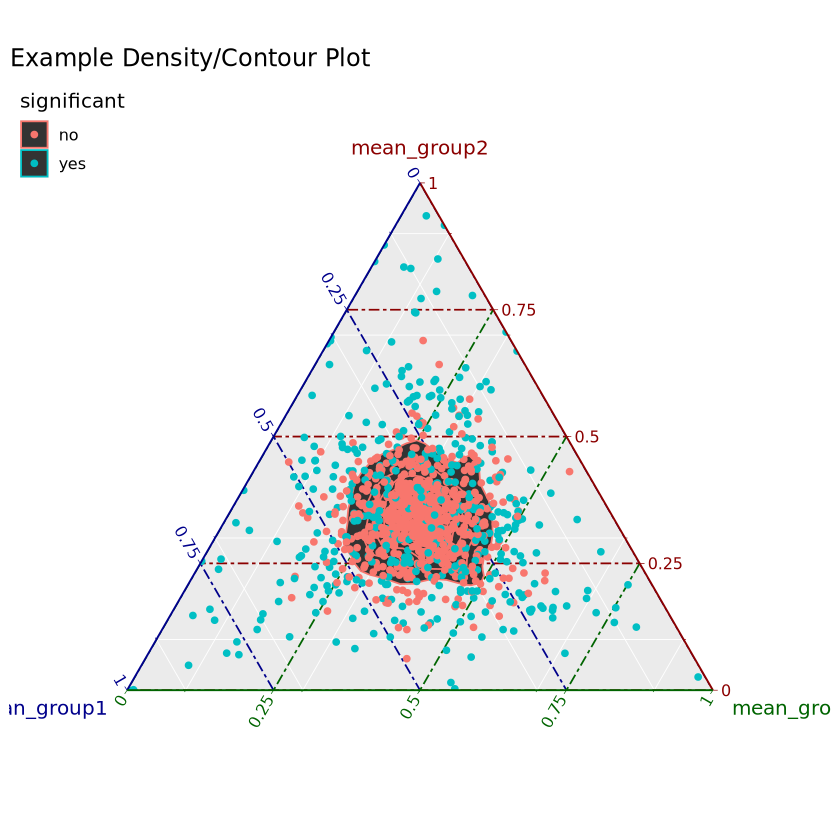

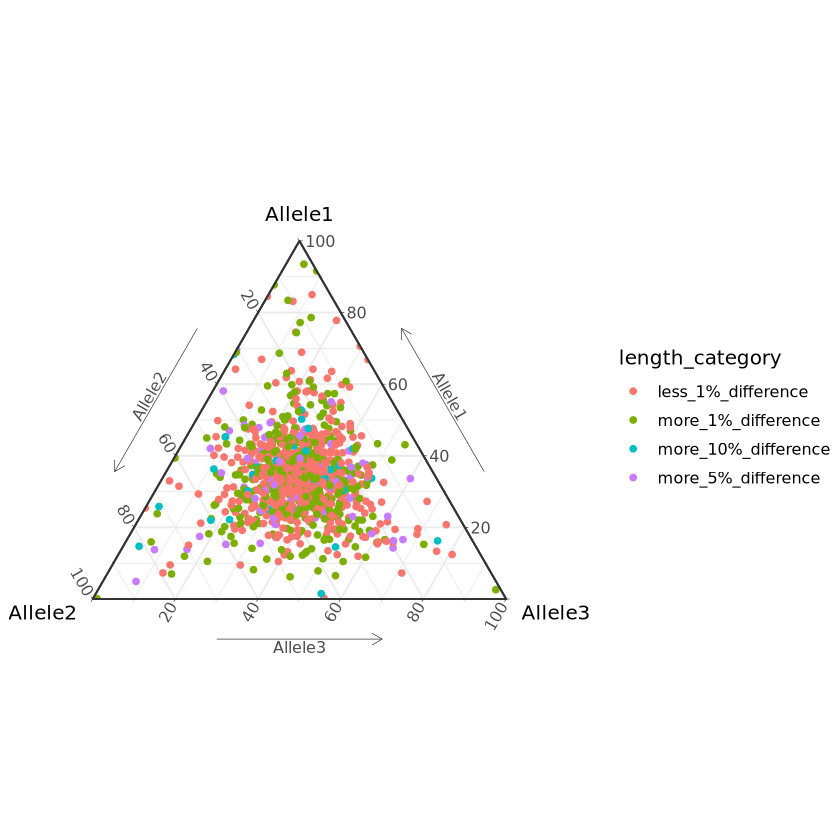

significant,n
<chr>,<int>
no,667
yes,402


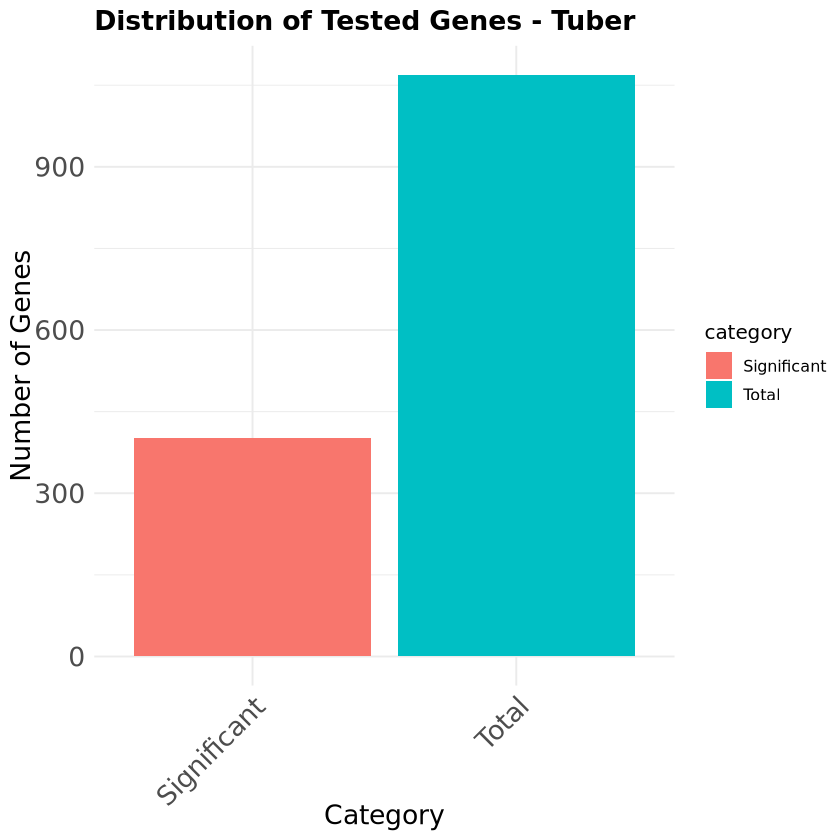

In [20]:
result <- process_allele_data(syntelogs_tuber_50_non_multi_cpm, allele_suffixes = c("1", "2", "3", "4"), pivot_cols_prefix = "SRR")
melted_table <- result$melted_table
pivoted_table <- result$pivoted_table
results_df <- perform_anova_analysis(melted_table)
plots_and_summary_tuber <- analyze_significance_and_plot(results_df, raw_counts, sample_name = "Tuber", p_value_threshold = 0.01)
plots_and_summary_tuber$plot_significance
plots_and_summary_tuber$plot_length_category
plots_and_summary_tuber$bar_plot
View(plots_and_summary_tuber$significance_summary)
#grid.arrange(plot1, plot2, plot3, ncol=2)

# DM allele overexpressed?

## Go Enrichment

In [3]:
#save the genes that are significant in tuber
sig_tuber = plots_and_summary_tuber$results_df[plots_and_summary_tuber$results_df$significant == "yes",]
#save the genes that are significant in leaf
# save a table
sig_leaf = plots_and_summary_leaf$results_df[plots_and_summary_leaf$results_df$significant == "yes",]
write.table(sig_tuber, file = "significant_syntelogs_tuber.tsv", sep = "\t", quote = FALSE, row.names = TRUE)


ERROR: Error: object 'plots_and_summary_tuber' not found


#### Tuber

In [10]:
go_term_file = "/scratch/nadjafn/reference/v6.1/DM_1-3_516_R44_potato.v6.1.working_models.iprscan_go_terms.txt"

In [11]:
# get the columns that contian adj p values
p_value_columns = colnames(plots_and_summary_tuber$results_df)[grep("_adj", colnames(plots_and_summary_tuber$results_df))]
# add the min p value to the dataframe
plots_and_summary_tuber$results_df$min_p_value = apply(plots_and_summary_tuber$results_df[,p_value_columns], 1, min)
# convert this to a list with the min p value and the gene id
#set synt id to rownames
p_value_list = plots_and_summary_tuber$results_df$min_p_value 
names(p_value_list) = plots_and_summary_tuber$results_df$Synt_id
topDiffGenes <- function(allScore) {
    return(allScore < 0.01)
}
sum(topDiffGenes(p_value_list))

BPterms <- ls(GOBPTerm)

geneID2GO <- readMappings(file = go_term_file, sep = "\t")
# Remove the .d suffix from gene IDs
names(geneID2GO) <- gsub("\\.\\d$", "", names(geneID2GO))
# remove the .0 after DM from the gene id
geneNames <- gsub("DM\\d\\.0", "DM", names(geneID2GO))
# remove the ./d from the gene id

# names(geneList) <- geneNames

GOdata <- new("topGOdata", ontology = "MF", allGenes = p_value_list,
            annot = annFUN.gene2GO, gene2GO = geneID2GO, geneSel = topDiffGenes)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
resultKS <- getSigGroups(GOdata, test.stat)
test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)


pvalFis <- score(resultFisher)

#hist(pvalFis, 50, xlab = "p-values")
allRes_tuber <- GenTable(GOdata, classic = resultFisher,  KS = resultKS,  ranksOf = "classic", topNodes = 20)
allRes_tuber

[1] 402


Building most specific GOs .....

	( 262 GO terms found. )


Build GO DAG topology ..........

	( 479 GO terms and 617 relations. )


Annotating nodes ...............

	( 612 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 317 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test


			 -- Classic Algorithm -- 

		 the algorithm is scoring 479 nontrivial nodes
		 parameters: 
			 test statistic: KS tests
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 479 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	17 nodes to be scored	(0 eliminated genes)


	 Level 8:	36 nodes to be scored	(0 eliminated genes)


	 Level 7:	68 nodes to be scored	(0 eliminated genes)


	 Level 6:	120 nodes to be scored	(4 eliminated genes)


	 Level 5:	110 nodes to be scored	(12 eliminated genes)


	 Level 4:	83 nodes to be scored	(15 eliminated ge

,GO.ID,Term,Annotated,Significant,Expected,Rank in classic,classic,KS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
1,GO:0003735,structural constituent of ribosome,40,26,15.69,1,0.00059,0.00064
2,GO:0008324,monoatomic cation transmembrane transpor...,15,12,5.88,2,0.00139,0.00083
3,GO:0005198,structural molecule activity,46,28,18.04,3,0.00168,0.00070
4,GO:0015318,inorganic molecular entity transmembrane...,14,11,5.49,4,0.00295,0.00202
5,GO:0022890,inorganic cation transmembrane transport...,14,11,5.49,5,0.00295,0.00202
6,GO:0015075,monoatomic ion transmembrane transporter...,16,12,6.27,6,0.00363,0.00255
7,GO:0015078,proton transmembrane transporter activit...,11,9,4.31,7,0.00473,0.00318
8,GO:0022853,active monoatomic ion transmembrane tran...,8,7,3.14,8,0.00717,0.00013
9,GO:0022804,active transmembrane transporter activit...,9,7,3.53,9,0.02146,0.00081


### Go Leaf

In [12]:
# get the columns that contian adj p values
p_value_columns = colnames(plots_and_summary_leaf$results_df)[grep("_adj", colnames(plots_and_summary_leaf$results_df))]
# add the min p value to the dataframe
plots_and_summary_leaf$results_df$min_p_value = apply(plots_and_summary_leaf$results_df[,p_value_columns], 1, min)
# convert this to a list with the min p value and the gene id
#set synt id to rownames
p_value_list = plots_and_summary_leaf$results_df$min_p_value 
names(p_value_list) = plots_and_summary_leaf$results_df$Synt_id
topDiffGenes <- function(allScore) {
    return(allScore < 0.01)
}
sum(topDiffGenes(p_value_list))

BPterms <- ls(GOBPTerm)

geneID2GO <- readMappings(file = go_term_file, sep = "\t")
# Remove the .d suffix from gene IDs
names(geneID2GO) <- gsub("\\.\\d$", "", names(geneID2GO))
# remove the .0 after DM from the gene id
geneNames <- gsub("DM\\d\\.0", "DM", names(geneID2GO))
# remove the ./d from the gene id

# names(geneList) <- geneNames

GOdata <- new("topGOdata", ontology = "MF", allGenes = p_value_list,
            annot = annFUN.gene2GO, gene2GO = geneID2GO, geneSel = topDiffGenes)

test.stat <- new("classicCount", testStatistic = GOFisherTest, name = "Fisher test")
resultFisher <- getSigGroups(GOdata, test.stat)
test.stat <- new("classicScore", testStatistic = GOKSTest, name = "KS tests")
resultKS <- getSigGroups(GOdata, test.stat)
test.stat <- new("elimScore", testStatistic = GOKSTest, name = "Fisher test", cutOff = 0.01)
resultElim <- getSigGroups(GOdata, test.stat)


pvalFis <- score(resultFisher)

#hist(pvalFis, 50, xlab = "p-values")
allRes_tuber <- GenTable(GOdata, classic = resultFisher,  KS = resultKS,  ranksOf = "classic", topNodes = 20)
allRes_tuber

[1] 309


Building most specific GOs .....

	( 262 GO terms found. )


Build GO DAG topology ..........

	( 479 GO terms and 617 relations. )


Annotating nodes ...............

	( 612 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test


			 -- Classic Algorithm -- 

		 the algorithm is scoring 479 nontrivial nodes
		 parameters: 
			 test statistic: KS tests
			 score order: increasing


			 -- Elim Algorithm -- 

		 the algorithm is scoring 479 nontrivial nodes
		 parameters: 
			 test statistic: Fisher test
			 cutOff: 0.01
			 score order: increasing


	 Level 9:	17 nodes to be scored	(0 eliminated genes)


	 Level 8:	36 nodes to be scored	(0 eliminated genes)


	 Level 7:	68 nodes to be scored	(1 eliminated genes)


	 Level 6:	120 nodes to be scored	(6 eliminated genes)


	 Level 5:	110 nodes to be scored	(6 eliminated genes)


	 Level 4:	83 nodes to be scored	(10 eliminated gen

,GO.ID,Term,Annotated,Significant,Expected,Rank in classic,classic,KS
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
1,GO:0003824,catalytic activity,289,99,85.47,1,0.010,0.0223
2,GO:0046872,metal ion binding,55,24,16.27,2,0.014,0.0596
3,GO:0043169,cation binding,58,25,17.15,3,0.015,0.0632
4,GO:0016491,oxidoreductase activity,65,27,19.22,4,0.020,0.0016
5,GO:0004190,aspartic-type endopeptidase activity,3,3,0.89,5,0.026,0.0190
6,GO:0016627,"oxidoreductase activity, acting on the C...",3,3,0.89,6,0.026,0.0047
7,GO:0016628,"oxidoreductase activity, acting on the C...",3,3,0.89,7,0.026,0.0047
8,GO:0070001,aspartic-type peptidase activity,3,3,0.89,8,0.026,0.0190
9,GO:0016705,"oxidoreductase activity, acting on paire...",7,5,2.07,9,0.026,0.0130


In [13]:
# get pwd
getwd()

[1] "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/scripts"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


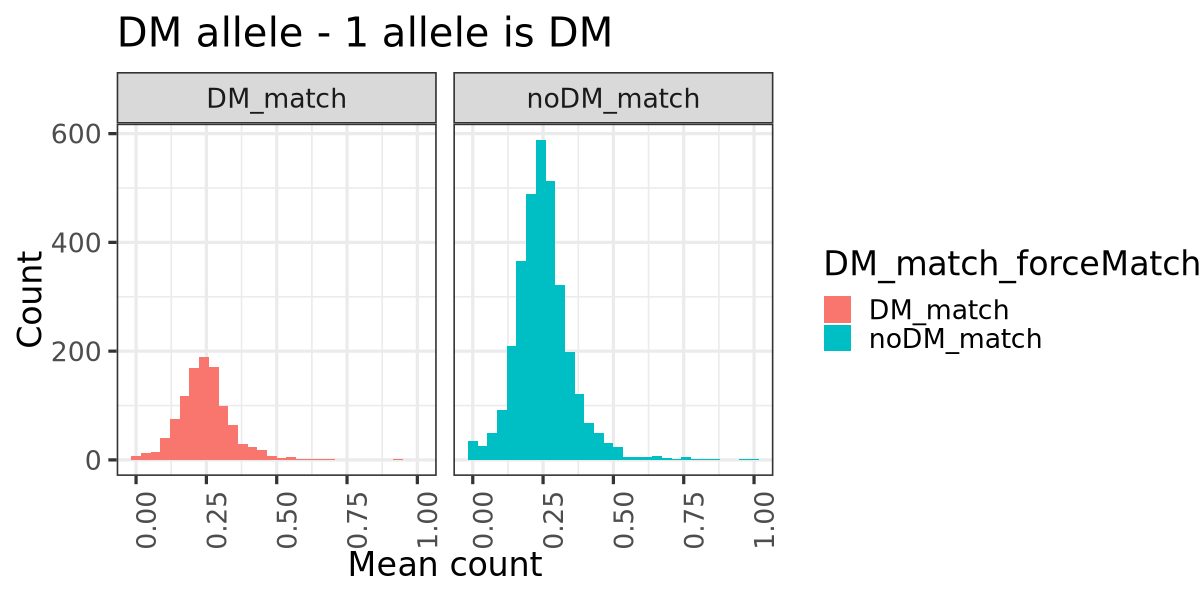

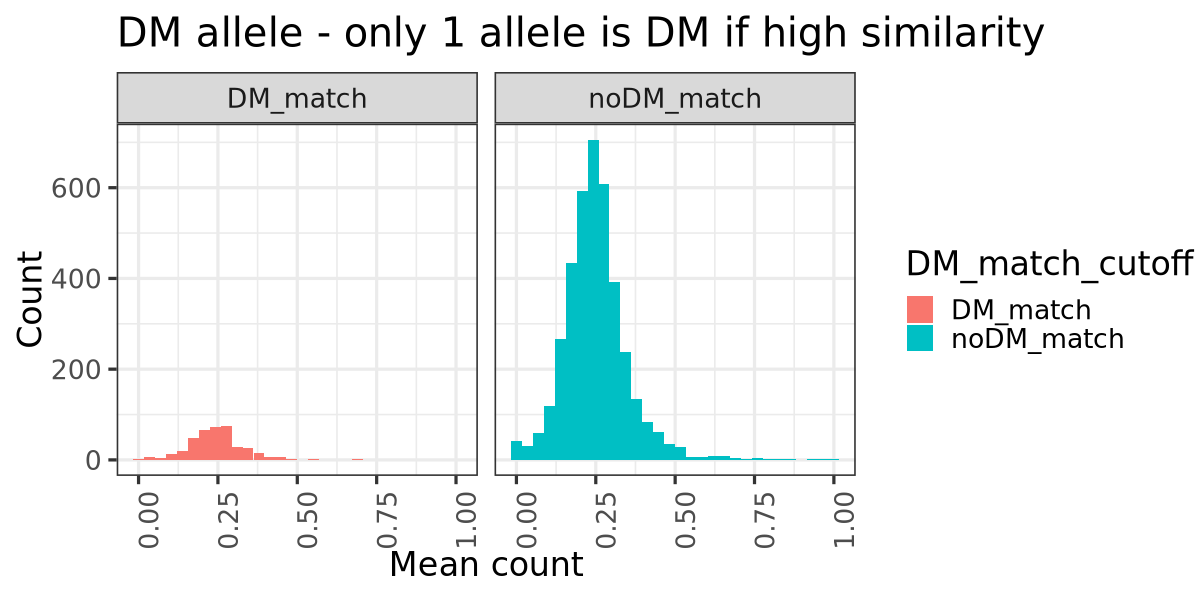

In [49]:
# select the genes that have a p value < 0.01
significant_genes = plots_and_summary_tuber$results_df #[plots_and_summary_tuber$results_df$min_p_value < 0.01,]
# select only the genes that contain 01G in the gene id

# pivot the table so that hap1 hap
# make a boxplot of the mean_group1, mean_group2, mean_group3, mean_group4
significant_genes_long = significant_genes %>% gather(key = "allele", value = "mean", starts_with("mean"))

# print sorted by Synt id
significant_genes_long = significant_genes_long[order(significant_genes_long$Synt_id),]

# if the mismatch_category and the allele have the same digit then change it to DM match otherise noDM_match
# get the digit from mismatch_category_forceMatch
significant_genes_long$mismatch_category_forceMatch_digit = str_extract(significant_genes_long$mismatch_category_forceMatch, "\\d")
significant_genes_long$mismatch_category_cutoff_digit = str_extract(significant_genes_long$mismatch_category_cutoff, "\\d")
# replace NaN with 0
significant_genes_long$mismatch_category_forceMatch_digit[is.na(significant_genes_long$mismatch_category_forceMatch_digit)] = 0
significant_genes_long$mismatch_category_cutoff_digit[is.na(significant_genes_long$mismatch_category_cutoff_digit)] = 0
significant_genes_long$allele_digit = str_extract(significant_genes_long$allele, "\\d")


significant_genes_long$DM_match_forceMatch = ifelse(significant_genes_long$mismatch_category_forceMatch_digit == significant_genes_long$allele_digit, "DM_match", "noDM_match")
significant_genes_long$DM_match_cutoff = ifelse(significant_genes_long$mismatch_category_cutoff_digit == significant_genes_long$allele_digit, "DM_match", "noDM_match")
# set the size of the plot
options(repr.plot.width=10, repr.plot.height=5)
# make a histogram of the mean counts per mismatch category for each allele
ggplot(significant_genes_long, aes(x = mean, fill = DM_match_forceMatch)) +
  geom_histogram() +
 theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
	title = "DM allele - 1 allele is DM",
	x = "Mean count",
	y = "Count"
  ) +
   facet_wrap(~ DM_match_forceMatch)


ggplot(significant_genes_long, aes(x = mean, fill = DM_match_cutoff)) +
  geom_histogram() +
  theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
	title = "DM allele - only 1 allele is DM if high similarity",
	x = "Mean count",
	y = "Count"
  ) +
   facet_wrap(~ DM_match_cutoff)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


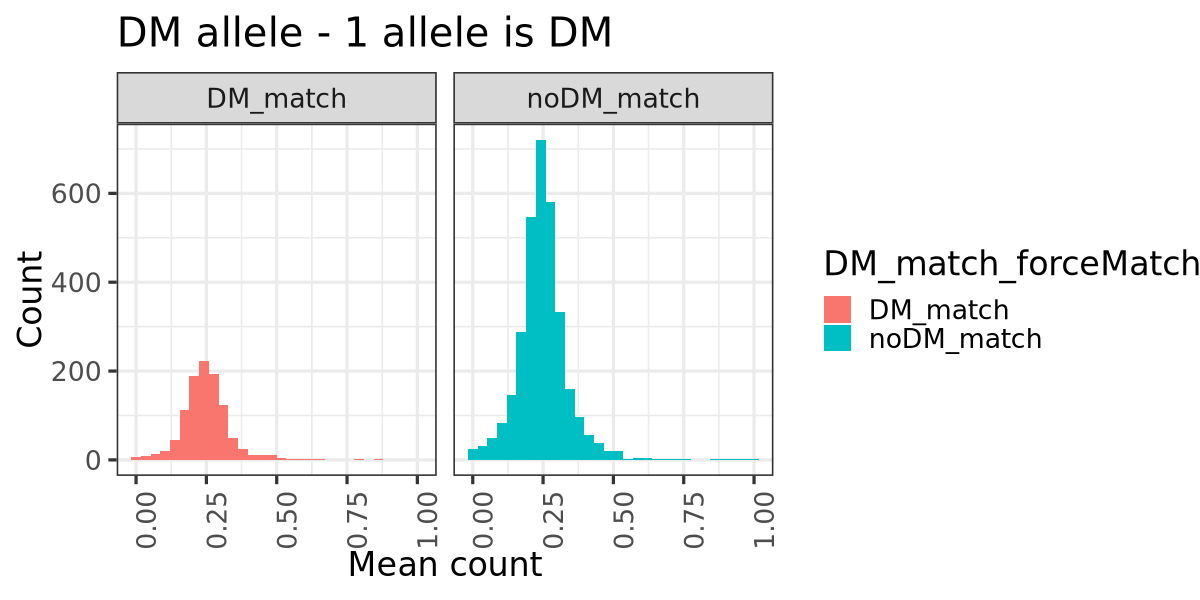

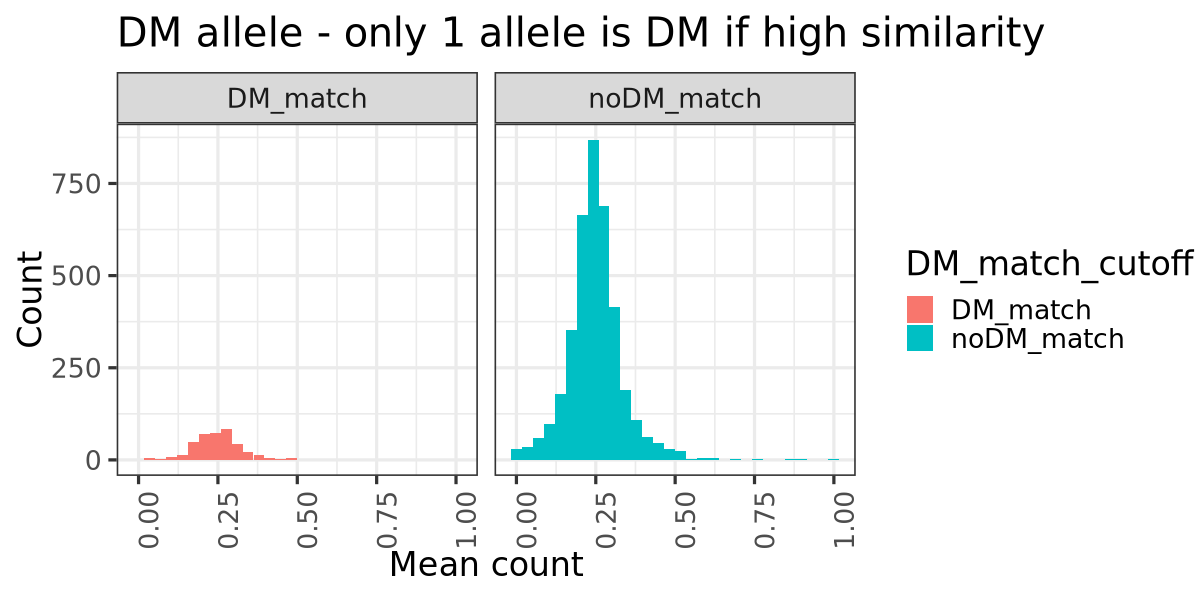

In [47]:
# select the genes that have a p value < 0.01
significant_genes = plots_and_summary_leaf$results_df #[plots_and_summary_leaf$results_df$min_p_value < 0.01,]
# select only the genes that contain 01G in the gene id

# pivot the table so that hap1 hap
# make a boxplot of the mean_group1, mean_group2, mean_group3, mean_group4
significant_genes_long = significant_genes %>% gather(key = "allele", value = "mean", starts_with("mean"))

# print sorted by Synt id
significant_genes_long = significant_genes_long[order(significant_genes_long$Synt_id),]

# if the mismatch_category and the allele have the same digit then change it to DM match otherise noDM_match
# get the digit from mismatch_category_forceMatch
significant_genes_long$mismatch_category_forceMatch_digit = str_extract(significant_genes_long$mismatch_category_forceMatch, "\\d")
significant_genes_long$mismatch_category_cutoff_digit = str_extract(significant_genes_long$mismatch_category_cutoff, "\\d")
# replace NaN with 0
significant_genes_long$mismatch_category_forceMatch_digit[is.na(significant_genes_long$mismatch_category_forceMatch_digit)] = 0
significant_genes_long$mismatch_category_cutoff_digit[is.na(significant_genes_long$mismatch_category_cutoff_digit)] = 0
significant_genes_long$allele_digit = str_extract(significant_genes_long$allele, "\\d")


significant_genes_long$DM_match_forceMatch = ifelse(significant_genes_long$mismatch_category_forceMatch_digit == significant_genes_long$allele_digit, "DM_match", "noDM_match")
significant_genes_long$DM_match_cutoff = ifelse(significant_genes_long$mismatch_category_cutoff_digit == significant_genes_long$allele_digit, "DM_match", "noDM_match")
# set the size of the plot
options(repr.plot.width=10, repr.plot.height=5)
# make a histogram of the mean counts per mismatch category for each allele
ggplot(significant_genes_long, aes(x = mean, fill = DM_match_forceMatch)) +
  geom_histogram() +
 theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
	title = "DM allele - 1 allele is DM",
	x = "Mean count",
	y = "Count"
  ) +
   facet_wrap(~ DM_match_forceMatch)


ggplot(significant_genes_long, aes(x = mean, fill = DM_match_cutoff)) +
  geom_histogram() +
  theme_bw(base_size = 20) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
	title = "DM allele - only 1 allele is DM if high similarity",
	x = "Mean count",
	y = "Count"
  ) +
   facet_wrap(~ DM_match_cutoff)


# Test for Normality and homogeneity of variance

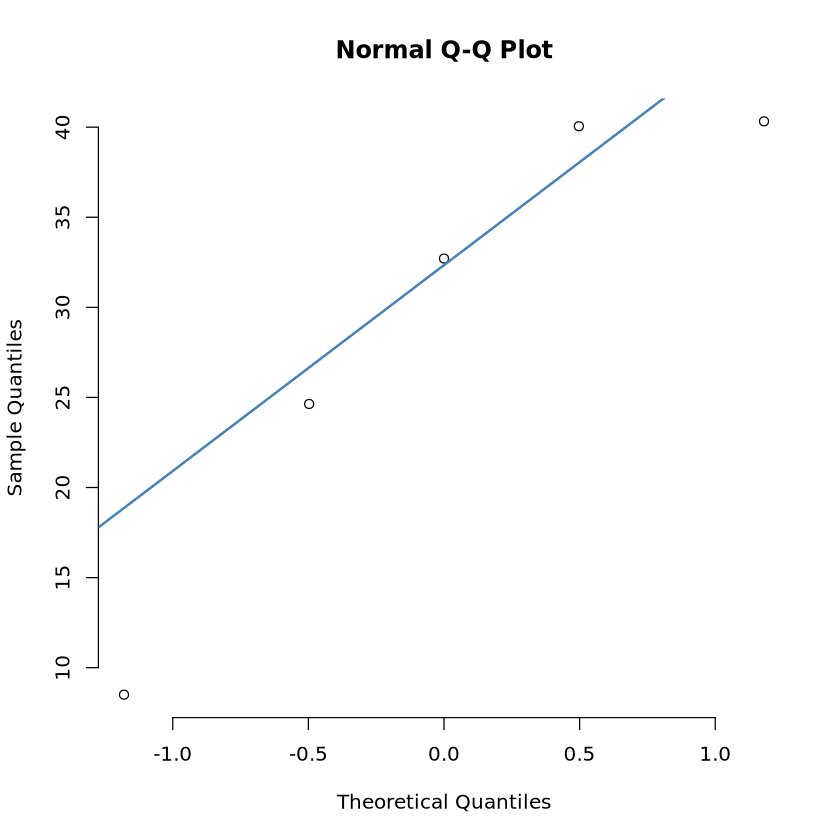

In [ ]:
melted_table = melted_table[melted_table$Synt_ids == "Soltu.DM.01G000010", ]#
my_data = melted_table[melted_table$allele == "allele_3",]

qqnorm(my_data$value, pch = 1, frame = FALSE)
qqline(my_data$value, col = "steelblue", lwd = 2)

In [17]:
# # select only allels 1 and 2
# melted_table = melted_table[melted_table$allele %in% c("allele_1", "allele_2"),]
# # test data for synt 261
# #melted_table = melted_table[melted_table$Synt_ids == "261",]

# # Split the data by unique Synt_id values
# split_data <- split(melted_table, melted_table$Synt_ids)

# # Use lapply to perform the operation on each subset and collect results
# results_list <- lapply(names(split_data), function(synt_id) {
#   test_data <- split_data[[synt_id]]
  
#   # Drop the rows where sum_allele is 0
#   test_data <- test_data[test_data$sum_counts != 0, ]
#   # Drop the rows where allele_1 is 0
#   #test_data <- test_data[test_data$allele_1 != 0, ]
#   # Check if there's enough data to perform the test
#   if (nrow(test_data) < 2) {
#     return(data.frame(
#       Synt_id = synt_id,
#       p_value = NA,
#       mean_group1 = NA,
#       mean_group2 = NA,
#       log_fold_change = NA
#     ))
#   }
  
#   # Perform the beta-Binomial test
#   test_result <- bb.test(
#     x = test_data$value,
#     tx = test_data$sum_counts,
#     group = test_data$allele,
#     n.threads = 10
#   )
  
#   # Calculate the means for the two groups
#   group_means <- aggregate(
#     cbind(value, sum_counts) ~ allele,
#     data = test_data,
#     FUN = sum
#   )
#   group_means$mean <- group_means$value/ group_means$sum_counts

#   # Ensure there are exactly two groups
#   if (nrow(group_means) != 2) {
#     return(data.frame(
#       Synt_id = synt_id,
#       p_value = NA,
#       mean_group1 = NA,
#       mean_group2 = NA,
#       log_fold_change = NA
#     ))
#   }
  
#   # Calculate log fold change
#   fold_change <- (group_means$mean[1] / group_means$mean[2])
  
#   # Create a data frame with the results
#   data.frame(
#     Synt_id = synt_id,
#     p_value = test_result$p.value,
#     mean_group1 = group_means$mean[1],
#     mean_group2 = group_means$mean[2],
#     fold_change = fold_change
#   )
# })

# # Combine the list of data frames into a single data frame
# results_df <- do.call(rbind, results_list)

In [18]:
results_df$p_adj = p.adjust(results_df$p_value, method = "fdr")
# add a column for significant genes werhe p_adj < 0.005
results_df$significant = ifelse(results_df$p_adj < 0.005 & (abs(results_df$mean_group1 - results_df$mean_group2) > 0.2), "red", "blue")
plot(results_df$mean_group1, results_df$mean_group2, xlab = "Allele 1", ylab = "Allele 2", main = "Allele 1 vs Allele 2",  col = results_df$significant, pch = 19, ylim = c(0,1), xlim = c(0,1))
# label the points that are red
text(results_df$mean_group1[results_df$significant == "red"], results_df$mean_group2[results_df$significant == "red"], labels = results_df$Synt_id[results_df$significant == "red"], pos = 3)

ERROR: Error in `$<-.data.frame`(`*tmp*`, p_adj, value = numeric(0)): replacement has 0 rows, data has 1069


In [ ]:
# count the number of significant genes
# filter the results_df for significant genes
results_df_significant = results_df[results_df$p_adj < 0.05,]
# group the results by synt id
results_df_significant_grouped = results_df_significant %>% group_by(Synt_id) %>% summarise(n = n())
nrow(results_df_significant_grouped)
dim( results_df)

[1] 254

[1] 435   7

# Functions

### Anova function